In [ ]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

In [1]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext Cython

In [3]:
# PASSWORDS AND STUFF HERE

In [4]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [5]:
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

In [6]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

55


In [17]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=128):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            w = 512 + 2 * highpass
            if start - w > 0:
                raw   = self.data[start - w:stop]
                spec  = fwd_spectrogram(raw, win=w)[:, 0:256] 
                t,d   = spec.shape
                if t >= self.win:
                    current = []        
                    for i in range(self.win, t + 1, self.win // 2):
                        x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                        mu     = np.mean(x)
                        std    = np.std(x) + 1.0
                        window = (x - mu) / std
                        current.append(window)
                    self.i += 1
                    return np.stack(current)
                else:
                    self.i += 1
                    return None
            else:
                self.i += 1
                return None
        else:
            raise StopIteration                    
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [18]:
encoder = load_model('../models/lstm_v3/v3.5/encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])
    print(path, len(latent), len(regions_by_file[path]))

Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05291103.m4a 2133 10
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06151101.m4a 2150 18
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/07141102C.m4a 2157 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/07291101.m4a 2162 5
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261101C.m4a 2174 13
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/06121101.m4a 2485 311
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/07131102.m4a 2526 41
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05261103C.m4a 2532 6
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05281101.m4a 2558 26
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/07141101C.m4a 2565 7
Infile converted from .m4a to ".wav"
data read in!
audio_files/2011/05281103.m4a 2566 1
Infile converted from

In [19]:
import pickle
print(len(latent))
pickle.dump( latent, open( "data.p", "wb" ) )

3594


3594


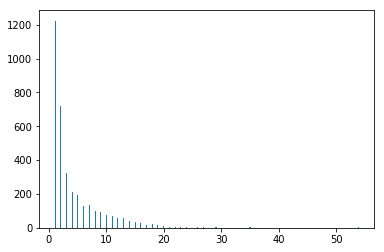

In [20]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [21]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 4), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                dp[i - 1][j    ],
                dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

3594
0 / 3594
10 / 3594
20 / 3594
30 / 3594
40 / 3594
50 / 3594
60 / 3594
70 / 3594
80 / 3594
90 / 3594
100 / 3594
110 / 3594
120 / 3594
130 / 3594
140 / 3594
150 / 3594
160 / 3594
170 / 3594
180 / 3594
190 / 3594
200 / 3594
210 / 3594
220 / 3594
230 / 3594
240 / 3594
250 / 3594
260 / 3594
270 / 3594
280 / 3594
290 / 3594
300 / 3594
310 / 3594
320 / 3594
330 / 3594
340 / 3594
350 / 3594
360 / 3594
370 / 3594
380 / 3594
390 / 3594
400 / 3594
410 / 3594
420 / 3594
430 / 3594
440 / 3594
450 / 3594
460 / 3594
470 / 3594
480 / 3594
490 / 3594
500 / 3594
510 / 3594
520 / 3594
530 / 3594
540 / 3594
550 / 3594
560 / 3594
570 / 3594
580 / 3594
590 / 3594
600 / 3594
610 / 3594
620 / 3594
630 / 3594
640 / 3594
650 / 3594
660 / 3594
670 / 3594
680 / 3594
690 / 3594
700 / 3594
710 / 3594
720 / 3594
730 / 3594
740 / 3594
750 / 3594
760 / 3594
770 / 3594
780 / 3594
790 / 3594
800 / 3594
810 / 3594
820 / 3594
830 / 3594
840 / 3594
850 / 3594
860 / 3594
870 / 3594
880 / 3594
890 / 3594
900 / 3594
910 /

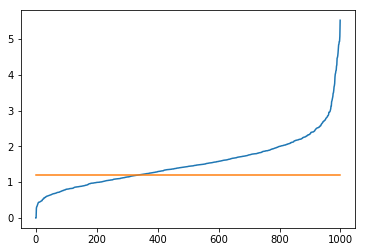

1.1950091560681662


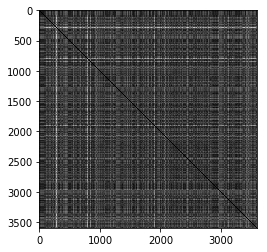

In [22]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f,30)

plt.plot(sorted(f[0:1000]))
plt.plot(np.ones(1000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]

plt.imshow(distances, cmap='gray')
plt.show()

In [23]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [24]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [25]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [26]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='average', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [27]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [34]:
final_clustering = [c for c in c if len(c) > 1]
pickle.dump(final_clustering, open( "final_clustering.p", "wb" ) )
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

193
[13, 3, 2, 3, 2, 12, 5, 7, 15, 22, 8, 2, 2, 2, 10, 2, 3, 3, 8, 3, 579, 3, 2, 3, 5, 2, 2, 4, 2, 2, 2, 2, 14, 6, 8, 3, 3, 10, 14, 4, 2, 4, 14, 3, 5, 3, 2, 4, 2, 2, 3, 2, 4, 5, 2, 4, 2, 4, 2, 2, 2, 2, 9, 4, 3, 2, 2, 2, 2, 4, 6, 17, 3, 7, 2, 2, 2, 11, 7, 2, 6, 23, 5, 2, 2, 4, 5, 3, 3, 2, 2, 34, 4, 4, 6, 3, 1650, 4, 3, 2, 2, 9, 5, 3, 2, 2, 2, 2, 6, 3, 3, 3, 2, 2, 10, 3, 4, 2, 2, 9, 2, 2, 3, 2, 3, 2, 3, 5, 3, 2, 4, 2, 3, 102, 4, 2, 2, 2, 5, 3, 2, 4, 6, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 4, 2, 2, 5, 2, 2, 2, 2, 5, 3, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 4, 4, 3, 12, 2, 7, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 5, 2]
3113


In [ ]:
from scipy.io import wavfile
import sys
from google.cloud import storage
import pickle
import random 

final_clustering = pickle.load(open( "final_clustering.p", "rb" ))

print(len(final_clustering))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))

cache = {}
client = storage.Client.from_service_account_json('../secret.json')
bucket = client.get_bucket('wdp-data')

cx = 0
skip = 0
for cluster in final_clustering:
    if cx >= skip:
        n = len(cluster)
        print("Cluster: {}".format(n))
        audio = []
        sampled_cluster = cluster.copy()
        random.shuffle(sampled_cluster)
        sampled_cluster = sampled_cluster[:10]
        for i, region in enumerate(cluster):
            path = "audio_files/{}/{}".format(region['year'], region['filename'])
            if path in cache:
                stream = cache[path]
            else:                
                with open("/tmp/audio.m4a", "wb") as file_obj:
                    blob = bucket.blob(path)
                    blob.download_to_file(file_obj)
                stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
                cache[path] = stream              
                print(sys.getsizeof(cache))
            spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
            audio.extend(stream.data[region['start']:region['stop']])
            audio.extend(np.zeros(stream.fs // 10))    
        audio = np.array(audio, dtype=audio[0].dtype)
        wavfile.write('../data/results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1

193
[13, 3, 2, 3, 2, 12, 5, 7, 15, 22, 8, 2, 2, 2, 10, 2, 3, 3, 8, 3, 579, 3, 2, 3, 5, 2, 2, 4, 2, 2, 2, 2, 14, 6, 8, 3, 3, 10, 14, 4, 2, 4, 14, 3, 5, 3, 2, 4, 2, 2, 3, 2, 4, 5, 2, 4, 2, 4, 2, 2, 2, 2, 9, 4, 3, 2, 2, 2, 2, 4, 6, 17, 3, 7, 2, 2, 2, 11, 7, 2, 6, 23, 5, 2, 2, 4, 5, 3, 3, 2, 2, 34, 4, 4, 6, 3, 1650, 4, 3, 2, 2, 9, 5, 3, 2, 2, 2, 2, 6, 3, 3, 3, 2, 2, 10, 3, 4, 2, 2, 9, 2, 2, 3, 2, 3, 2, 3, 5, 3, 2, 4, 2, 3, 102, 4, 2, 2, 2, 5, 3, 2, 4, 6, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 4, 2, 2, 5, 2, 2, 2, 2, 5, 3, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 4, 4, 3, 12, 2, 7, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 5, 2]
CLUSTERS:  193
Cluster: 13
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
288
Infile converted from .m4a to ".wav"
data read in!
288


In [15]:
max_id = run_query("""
    SELECT 
        max(id)
    FROM 
        wdp_ds.clustering_results
    """)
if max_id[0]['max(id)'] is None:
    max_id = 0
else:
    max_id = max_id[0]['max(id)']
print(max_id)

0


In [16]:
with db.connect() as conn:
    id = 0
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_lstm_v3_5', r['cluster'])        
            conn.execute(query)  
            id += 1